In [1]:
import pandas as pd
import numpy as np

In [2]:
!ls ./人脸关键点检测挑战赛_数据集/ -l

总用量 611464
-rw-rw-r-- 1 lyz lyz     49324 8月   5 16:54 sample_submit.csv
-rw-rw-r-- 1 lyz lyz 151068800 7月  31 18:11 test.npy
-rw-rw-r-- 1 lyz lyz  30636709 8月   5 16:57 test.npy.zip
-rw-rw-r-- 1 lyz lyz    577557 8月   5 16:54 train.csv
-rw-rw-r-- 1 lyz lyz 368640128 7月  31 18:11 train.npy
-rw-rw-r-- 1 lyz lyz  75144987 8月   5 16:57 train.npy.zip


In [3]:
train_df = pd.read_csv('人脸关键点检测挑战赛_数据集/train.csv')
train_df = train_df.fillna(48)
train_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.342364,38.523613,28.930840,35.577773,49.256845,68.275955,47.783946,85.361582
1,68.912604,31.409117,29.652226,33.028075,51.913358,48.408453,50.698868,79.574038
2,68.708994,40.371149,27.130820,40.940680,44.502523,69.988486,45.926427,86.221009
3,65.334176,35.471878,29.366461,37.767684,50.411373,64.934767,50.028780,74.883241
4,68.634857,29.999486,31.094571,29.616429,50.247429,51.450857,47.948571,84.394286


In [4]:
train_img = np.load('人脸关键点检测挑战赛_数据集/train.npy')
test_img = np.load('人脸关键点检测挑战赛_数据集/test.npy')

print(train_img.shape, test_img.shape)

(96, 96, 5000) (96, 96, 2049)


Populating the interactive namespace from numpy and matplotlib


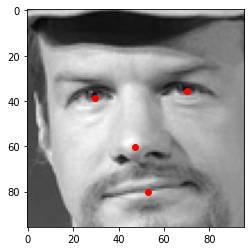

In [5]:
%pylab inline
idx = 409
xy = train_df.iloc[idx].values.reshape(-1, 2)
plt.scatter(xy[:, 0], xy[:, 1], c='r')
plt.imshow(train_img[:, :, idx], cmap='gray')

Populating the interactive namespace from numpy and matplotlib


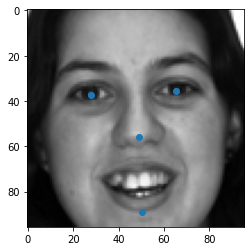

In [6]:
%pylab inline
idx = 400
xy = train_df.iloc[idx].values.reshape(-1, 2)
plt.scatter(xy[:, 0], xy[:, 1])
plt.imshow(train_img[:, :, idx], cmap='gray')

In [7]:
import os, sys, codecs, glob
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import cv2

import torch
torch.backends.cudnn.benchmark = False
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

In [8]:
class XunFeiDataset(Dataset):
    def __init__(self, img, keypoint, transform=None):
        self.img = img
        self.transform = transform
        self.keypoint = keypoint

    def __getitem__(self, index):
        img = Image.fromarray(self.img[:, :, index]).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, self.keypoint[index] / 96.0

    def __len__(self):
        return self.img.shape[-1]

In [9]:
train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_img[:, :, :-500], train_df.values[:-500],
                    transforms.Compose([
                        transforms.ToTensor(),
        ])
    ),
    batch_size=10, shuffle=True, num_workers=5,
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_img[:, :, -500:], train_df.values[-500:],
                    transforms.Compose([
                        transforms.ToTensor(),
        ])
    ),
    batch_size=10, shuffle=False, num_workers=5,
)

In [10]:
train_img[:, :, -500:].shape

(96, 96, 500)

In [11]:
import timm

class XunFeiNet(nn.Module):
    def __init__(self):
        super(XunFeiNet, self).__init__()
        self.model = timm.create_model('efficientnet_b2', num_classes=8, 
                          pretrained=True)
        
    def forward(self, img, labels=None):        
        feat = self.model(img)
        return feat
    
model = XunFeiNet().cuda()

In [12]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True).float()
        target = target.cuda(non_blocking=True).float()

        output = model(input, target)
        loss = criterion(output, target)
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        loss.backward()
        optimizer.step()
        
        if i % 200 == 0:
            print(loss.item())
            
def validate(val_loader, model):
    model.eval()
    
    val_feats = []
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda().float()
            target = target.cuda().float()
            output = model(input)
            val_feats.append(output.data.cpu().numpy())
    return val_feats

In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5)
fold = 0
for tr_idx, val_idx, in kfold.split([1]*train_img.shape[-1]):
    train_loader = torch.utils.data.DataLoader(
        XunFeiDataset(train_img[:, :, tr_idx], train_df.values[tr_idx],
                        transforms.Compose([
                            transforms.ToTensor(),
            ])
        ),
        batch_size=10, shuffle=True, num_workers=5,
    )

    val_loader = torch.utils.data.DataLoader(
        XunFeiDataset(train_img[:, :, val_idx], train_df.values[val_idx],
                        transforms.Compose([
                            transforms.ToTensor(),
            ])
        ),
        batch_size=10, shuffle=False, num_workers=5,
    )

    model = XunFeiNet().cuda()
    criterion = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), 0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.85)
    best_acc = 0.0

    for epoch in range(5):
        print('Epoch: ', epoch)

        train(train_loader, model, criterion, optimizer, epoch)

        val_feats = validate(val_loader, model)
        scheduler.step()

        val_feats = np.vstack(val_feats) * 96
        print('Val', mean_absolute_error(val_feats, train_df.values[val_idx]))
    
    torch.save(model.state_dict(), 'model_{0}.pt'.format(fold))
    fold += 1


Epoch:  0
9.905308723449707
0.04050697386264801
Val 9.251546502541116
Epoch:  1
0.013120531104505062
0.009193876758217812
Val 6.183500956023397
Epoch:  2
0.005100372713059187
0.0034459661692380905
Val 4.663692081580198
Epoch:  3
0.0024106167256832123
0.0026592991780489683
Val 3.9134228048808497
Epoch:  4
0.002302343724295497
0.002632445190101862
Val 4.080580439451729
Epoch:  0
14.201547622680664
0.044054899364709854
Val 15.468229983963187
Epoch:  1
0.017920926213264465
0.006700710393488407
Val 7.576506788692038
Epoch:  2
0.006524837110191584
0.007065281271934509
Val 5.77656327253138
Epoch:  3
0.007522534113377333
0.005034391302615404
Val 4.758780754738569
Epoch:  4
0.00238896650262177
0.0033426203299313784
Val 3.790834823154542
Epoch:  0
12.44189167022705
0.035967353731393814
Val 9.075832300863373
Epoch:  1
0.008467060513794422
0.005924645811319351
Val 8.542295129004941
Epoch:  2
0.005121264141052961
0.004584698472172022
Val 4.53243985315707
Epoch:  3
0.0037631846498697996
0.0026907247

In [22]:
test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_img, np.zeros((2049, 8)),
                    transforms.Compose([
                        transforms.ToTensor(),
        ])
    ),
    batch_size=10, shuffle=False, num_workers=5,
)

In [23]:
pred_tta = []
for path in ['model_0.pt','model_1.pt','model_2.pt',
            'model_3.pt','model_4.pt']:
    pred = []
    model.load_state_dict(torch.load(path))
    with torch.no_grad():
        for t, (x, y) in enumerate(test_loader):
            x_var = Variable(x).cuda(async=True)
            y_var = Variable(y).cuda()
            scores = model(x_var)
            pred.append(scores.data.cpu().numpy())
    pred = np.concatenate(pred, 0)    
    print(path)
    pred_tta.append(pred)

pred = np.mean(pred_tta, axis=0)

0
0
0
0
0


In [24]:
col = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
 'right_eye_center_y', 'nose_tip_x', 'nose_tip_y', 
 'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y']
pd.DataFrame(pred * 96, columns=col).to_csv('submit.csv', index=None)